# IMDB with PyTorch


## IMDB Movie Review Sentiment Analysis

Import libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 
EDA

In [60]:
data = pd.read_csv("C:\IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [61]:
def transform_label(label):
    return 1 if label == 'positive' else 0
data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 806162.84it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [62]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [63]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:00<00:00, 63137.64it/s]


In [64]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [65]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

<Figure size 360x576 with 0 Axes>

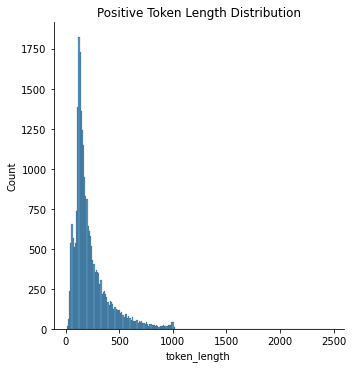

In [66]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 360x576 with 0 Axes>

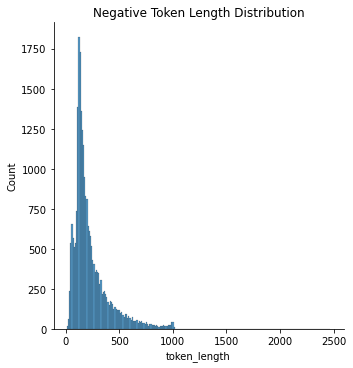

In [67]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [68]:
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


# 
Clean and Preprocess

In [69]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
def rm_punct2(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)
def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     
    s = re.sub(r'\s{2,}', ' ', s)         
    return s
def rm_number(text):
    return re.sub(r'\d+', '', text)
def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)
def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)
def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF'  
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)
def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)
def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [70]:
def tokenize(text):
    return word_tokenize(text)
def rm_stopwords(text):
    return [i for i in text if i not in stopwords]
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return rm_stopwords(lemmas)
def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [71]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [72]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [02:13<00:00, 374.22it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [73]:
data[['processed', 'label']].to_csv('C:IMDB Dataset.csv', index=False, header=True)

# 
Prepare Dataset

In [74]:
data = pd.read_csv("C:/Users/91983/Downloads/IMDB Dataset.csv")
for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')    
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

In [75]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()
words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [76]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [77]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]
for i in range(5):
    print(reviews_enc[i][:5])

100%|██████████| 50000/50000 [00:04<00:00, 10827.03it/s]


[191, 1083, 930, 81, 3724]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1041]
[2408, 136, 59, 241, 3230]
[70982, 10566, 1081, 1941, 7538]


In [78]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]
    return features
seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)
assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length
features[:10, :10]

array([[  191,  1083,   930,    81,  3724,   186,  3030,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1267,  1608, 17875,
            4],
       [    3,    95,   328,    30,  1041,    13,   845,  1774,  2633,
            2],
       [ 2408,   136,    59,   241,  3230,    37,   650,  4298,   583,
          882],
       [70982, 10566,  1081,  1941,  7538,  2280,  1313,     6,    46,
            1],
       [ 2795,     4,    13,   368,     5,     2,    17, 42503,     2,
         2952],
       [    3,   197,    18,    10,    21, 12517,  1904, 55922,   121,
         5112],
       [   14,    31,   427,     2,  1342,  4021,   165,    34,  2960,
            1],
       [47893,   980,   359,     6,     3,   180,   776,    81,     6,
            1],
       [   64,    10,   125,  2269,  5606,  1980,    10,     5,     1,
           64]])

In [79]:
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [80]:
train_size = .7    
val_size = .5      
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]
print('Feature Shapes:')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [81]:
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


In [82]:
batch_size = 128
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [83]:
dataiter = iter(trainloader)
x, y = dataiter.next()
print('Sample batch size: ', x.size())   
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())  
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[15259, 27974,  4519,  ...,   284,  6900,   299],
        [   11,    18,  5013,  ...,  3082, 14818,  5186],
        [    3,   264,  1400,  ...,    22,  2348,  2909],
        ...,
        [44133, 30298,   176,  ...,     0,     0,     0],
        [   11,   288,     5,  ...,     0,     0,     0],
        [   14,     5,   102,  ...,     0,     0,     0]], dtype=torch.int32)

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0])


# 
Modelling

In [84]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ =  self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)
        return o

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [86]:
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(121301, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [87]:
lr = 0.001
criterion = nn.BCELoss()  
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

# 
PyTorch

In [88]:
model = model.to(device)
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)
es_trigger = 0
val_loss_min = torch.inf
for e in epochloop:
    model.train()
    train_loss = 0
    train_acc = 0
    for id, (feature, target) in enumerate(trainloader):
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')
        feature, target = feature.to(device), target.to(device)
        optim.zero_grad()
        out = model(feature)
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()
        del feature, target, predicted
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            feature, target = feature.to(device), target.to(device)
            out = model(feature)
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()
            del feature, target, predicted
        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))
    model.train()
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history['epochs'] = e+1
        break

Training:  12%|█▎        | 1/8 [3:44:13<26:09:36, 13453.84s/it, Val Loss: 0.698 | Val Acc: 0.505]

Epoch 1/8 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.698 Val Acc: 0.505


Training:  38%|███▊      | 3/8 [4:54:04<6:50:19, 4923.85s/it, Training batch 0/274]              

Epoch 2/8 | Train Loss: 0.685 Train Acc: 0.548 | Val Loss: 0.698 Val Acc: 0.507
[WARNING] Validation loss did not improved (0.698 --> 0.698)


Training:  50%|█████     | 4/8 [5:59:45<5:02:22, 4535.64s/it, Val Loss: 0.692 | Val Acc: 0.514]

Epoch 3/8 | Train Loss: 0.688 Train Acc: 0.512 | Val Loss: 0.692 Val Acc: 0.514


Training:  75%|███████▌  | 6/8 [7:14:54<1:54:54, 3447.20s/it, Val Loss: 0.691 | Val Acc: 0.512]

Epoch 4/8 | Train Loss: 0.676 Train Acc: 0.551 | Val Loss: 0.691 Val Acc: 0.512


Training:  88%|████████▊ | 7/8 [8:24:48<1:01:31, 3691.32s/it, Val Loss: 0.465 | Val Acc: 0.816]

Epoch 5/8 | Train Loss: 0.519 Train Acc: 0.740 | Val Loss: 0.465 Val Acc: 0.816


Training: 100%|██████████| 8/8 [9:25:34<00:00, 3676.71s/it, Val Loss: 0.356 | Val Acc: 0.849]  

Epoch 6/8 | Train Loss: 0.312 Train Acc: 0.879 | Val Loss: 0.356 Val Acc: 0.849


Training: 10it [10:29:35, 2933.10s/it, Val Loss: 0.349 | Val Acc: 0.862]                     

Epoch 7/8 | Train Loss: 0.215 Train Acc: 0.924 | Val Loss: 0.349 Val Acc: 0.862


Training: 100%|██████████| 8/8 [11:32:53<00:00, 5196.66s/it, Val Loss: 0.392 | Val Acc: 0.867]

Epoch 8/8 | Train Loss: 0.149 Train Acc: 0.952 | Val Loss: 0.392 Val Acc: 0.867
[WARNING] Validation loss did not improved (0.349 --> 0.392)


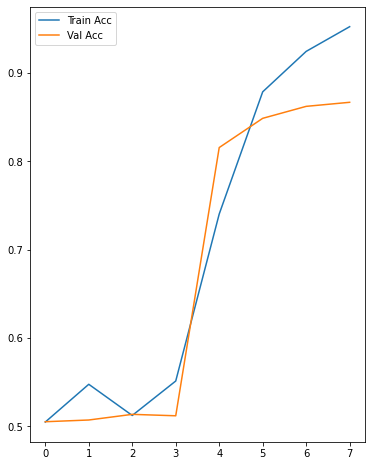

In [89]:
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

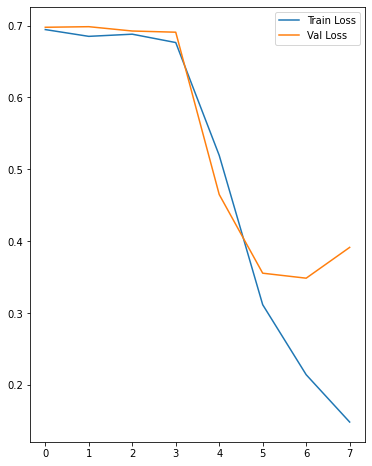

In [90]:
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# 
Inference

In [91]:
model.eval()
test_loss = 0
test_acc = 0
all_target = []
all_predicted = []
testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)
        out = model(feature)
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()
        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()
        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|██████████| 59/59 [03:50<00:00,  3.91s/it]

Accuracy: 0.8728, Loss: 0.3651


# 
Evaluation Metrics

In [92]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3721
           1       0.88      0.87      0.87      3779

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



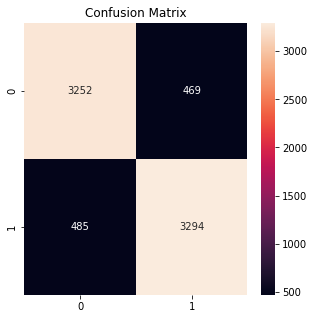

In [93]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()